# Train a Large Language Model from Scratch with a Custom Dataset and a Custom Tokenizer

# PARTS

* **PART A:** Transform our dataset from data in CSV Format
* **PART B:** Tokenization: Use a Pre-trained Tokenizer or Train a New Tokenizer from scratch?
* **PART C:** Build a Hugging Face Data Pipeline
* **PART D:** Train a Hugging Face Causal Language Model (Transformer) from scratch
* **PART E:** Generate Reviews with a Hugging Face Text Generation Pipeline

# **Part A:** Transform a Hugging Face Dataset from Data in CSV Format

## Install Generic Libraries

In [ ]:
import os
import re
import tensorflow as tf

* Record Each Cell's Execution Time

In [ ]:
!pip install ipython-autotime
%load_ext autotime

## Install the Transformers and Datasets libraries

In [ ]:
!pip install datasets transformers

## Install git-lfs

***Git Large File Storage (LFS)*** replaces large files such as audio samples, videos, datasets, and graphics with text pointers inside Git, while storing the file contents on a remote server like GitHub.com or Hugging Face.

For more information, refer to https://git-lfs.github.com/

* For local machines, install git-lfs as below.

In [ ]:
!apt install git-lfs

* For Jupyter Notebooks, install git-lfs as below:

In [ ]:
#!conda install -c conda-forge git-lfs -y

* Initialize Git LFS:

In [ ]:
!git lfs install

## Set up Git account
You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "1800002666@stu.iku.edu.tr"
!git config --global user.name "ahmetcangunay"

## Log in to Hugging Face Hub
You will also need to be logged in to the Hugging Face Hub. Therefore, first create an account the Hugging Face Hub and then execute the following command and enter your credentials.

In [ ]:
!git config --global credential.helper store

In This part, we should use Access Token with "Write" permission.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Prepare a Custom Dataset

## Load the custom dataset

Then, let's define the data directory and provide the data file name:

In [ ]:
path = r"E:\Corpus_Project\datasets_final\finished-corpus-as-text"

Let's use the ```load_dataset()``` method  from the Hugging Face ```datasets``` library.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("text", data_files= path)

### Upload Dataset to HuggingFace

In [ ]:
# If you would like to upload your dataset to HuggingFace, you could use this code snippet.
from huggingface_hub import HfApi
api = HfApi()

In [ ]:
# Load all txt files

api.upload_folder(
    folder_path= path,
    repo_id="ahmet1338/trained-model",
    path_in_repo="experiment/texts/",
    allow_patterns="*.txt", # Upload all local text files
)

### Check out the loaded dataset structure:

In [ ]:
dataset

Peek at the first few examples:

In [ ]:
dataset['train'][:2]

## Preprocess the dataset

Let’s define a simple function that counts the number of words in each text:

In [ ]:
def compute_sentence_length(example):
    return {"sentence_length": len(example["text"].split())}

When ```compute_sentence_length()``` is passed to ```Dataset.map()```, it will be applied to all the rows in the dataset to create a new ```sentence_length``` column:

In [ ]:
dataset = dataset.map(compute_sentence_length)
# Inspect the first training example
dataset[0]

As expected, we can see a ```sentence_length``` column has been added to our training set. We can sort this new column with ```Dataset.sort()``` to see what the extreme values look like:

In [ ]:
dataset.sort("sentence_length")[:3]

As we suspected, some texts contain just a few words, which, although it may be okay for sentiment analysis, would not be informative if we want to train or fine tune a causal language model.

Let’s use the ```Dataset.filter()``` function to remove texts that contain fewer than 30 words.

In [ ]:
dataset = dataset.filter(lambda x: x["sentence_length"] > 30)
print(dataset.num_rows)

As you can see, this has removed some of the texts from our original dataset.

Moreover, if you noticed that most of the texts end with the string "...Devamını oku" which means "...Read more".

In [ ]:
dataset[:3]

Also, notice that each text has actually a title which is the first statement until a comma and double quotation mark: ***,"***
We would like to replace these punctuations with a full stop.
Thus, we would like to remove these repeating strings as below:

In [ ]:
def remove_repeated(example):
    example["text"] = example["text"].replace('...', '')
    example["text"] = example["text"].replace(',"', '. ')
    example["text"] = example["text"].replace('!.', '.')
    example["text"] = example["text"].replace('!,', '. ')
    example["text"] = example["text"].replace('"', '')
    example["text"] = re.sub('([a-zA-Z0-9zığüşöçZİĞÜŞÖÇ]),([a-zA-Z0-9zığüşöçZİĞÜŞÖÇ])', '\\1. \\2', example["text"])

    return {"text": example["text"].replace('Devamını oku', '')}

Let's apply this function onto the dataset and inspect the first three training example:

In [ ]:
dataset = dataset.map(remove_repeated)
dataset[:3]

## Creating a validation set
🤗 Datasets provides a ```Dataset.train_test_split()``` function that is based on the famous functionality from ```scikit-learn```. Let’s use it to split our training set into train and validation splits (we set the seed argument for reproducibility):

In [ ]:
dataset = dataset.train_test_split(train_size=0.9, seed=42)
# Rename the default "test" split to "validation"
dataset["validation"] = dataset.pop("test")

dataset

In [ ]:
for key in dataset["train"][0]:
    print(f"{key.upper()}: {dataset['train'][0][key]}")

## Share the dataset to the Hub

Use the ```push_to_hub()``` function to help you add, commit, and push a file to your repository:

In [ ]:
dataset.push_to_hub("ahmet1338/turkish_corpus")

In [ ]:
downloaded_dataset = load_dataset("ahmet1338/turkish_corpus")
downloaded_dataset

# **PART B:** 🤗 Hugging Face Tokenization: Use a Pre-trained Tokenizer or Train a New Tokenizer from scratch?

For Tokenezation, we will use two different approaches:
* Use a pretrained tokenization
* Train a new tokenizer

### Use a pretrained tokenization (I applied pretrained tokenization, but I could not achieve the results I wanted. So you can skip this part or experiment on it.)


Let’s see exactly how this works by looking at the first two examples:

In [ ]:
from transformers import AutoTokenizer

context_length = 40 # It may also leave blank to tske whole sentence.
pretrained_tokenizer = AutoTokenizer.from_pretrained("redrussianarmy/gpt2-turkish-cased")

outputs = pretrained_tokenizer(
    dataset["train"][:2]["text"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=False,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
#print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

We can see that we get 6 **segments** in total from those two examples. Looking at the chunk lengths, we can see that the chunks at the ends of both documents have less than 40 tokens (1 and 7, respectively). These represent just a small fraction of the total chunks that we have, so we can safely throw them away. With the ```overflow_to_sample_mapping``` field, we can also reconstruct which chunks belonged to which input samples.

In [ ]:
print("vocab_size: ", len(pretrained_tokenizer))

Let's observe the generated tokend for a given string.

**Notice that** there are almost 10 words in the string however the number of the generated tokens is many more!

I will explain why it happens like this with the below example:

In [ ]:
txt = "Düşenin dostu olmaz derler kimileri. Sanki ayakta olanın dostu çokmuş gibi." # Cemal Süreya
tokens = pretrained_tokenizer(txt)['input_ids']
print(tokens)

We can convert back the tokens to strings:

In [ ]:
converted = pretrained_tokenizer.convert_ids_to_tokens(tokens)
print(converted)

### Train a new tokenizer

As suggested in the [official documentation](https://huggingface.co/course/chapter6/2?fw=pt), if a language model is not available in the language you are interested in, or if your corpus is very different from the one your language model was trained on, you will most likely want to retrain the model from scratch using a tokenizer adapted to your data. That will require training a new tokenizer on your dataset.

#### Create a data generator:



Using a Python generator, we can avoid Python loading anything into memory until it’s actually necessary.

The below generator will yield a ***batch*** of texts from the dataset at each request.

In [ ]:
def get_training_corpus():
    batch_size = 1000
    return (
        dataset["train"][i : i + batch_size]["text"]
        for i in range(0, len(dataset["train"]), batch_size)
    )
training_corpus = get_training_corpus()

Observe the ***size*** of the generator outputs below

In [ ]:
for texts in get_training_corpus():
    print(len(texts))

#### Training a new tokenizer:



Now that we have our corpus in the form of an ***iterator of batches*** of texts, we are ready to train a new tokenizer. To do this, we first need to load the tokenizer we want to pair with our model (here, GPT-2).

***Note 1:*** Even though we are going to train a new tokenizer, it’s a good idea to do this to avoid starting entirely from scratch. This way, we won’t have to specify anything about the tokenization algorithm or the special tokens we want to use; our new tokenizer will be exactly the same as GPT-2, and the only thing that will change is the vocabulary, which will be determined by the training on our corpus.

For this, we’ll use the method ```train_new_from_iterator()``` as below.

**Note 2:** This command might take a bit of time if your corpus is very large. Therefore, be patient or for experiment reasons use a small sample from the dataset.

In [ ]:
vocab_size = 52000
tokenizer = pretrained_tokenizer.train_new_from_iterator(training_corpus,vocab_size)

In [ ]:
tokenizer.eos_token_id

In [ ]:
tokenizer.vocab_size

Let’s try our brand new tokenizer on the previous example:

In [ ]:
txt = "Düşenin dostu olmaz derler kimileri. Sanki ayakta olanın dostu çokmuş gibi." # Cemal Süreya
tokens = tokenizer(txt)['input_ids']
print(tokens)

In [ ]:
converted = tokenizer.convert_ids_to_tokens(tokens)
print(converted)

In [ ]:
print(len(tokenizer.tokenize(txt)))
print(len(pretrained_tokenizer.tokenize(txt)))

#### Saving the tokenizer:


To make sure we can use it later, we need to save our new tokenizer. Like for models, this is done with the ```save_pretrained()``` method:


In [ ]:
path="./"
file_name="gpt_2_tokenizer_experimental"
tokenizer.save_pretrained(path+file_name)

In [ ]:
loaded_tokenizer = AutoTokenizer.from_pretrained("./gpt_2_tokenizer_experimental")

In [ ]:
txt = "Düşenin dostu olmaz derler kimileri. Sanki ayakta olanın dostu çokmuş gibi." # Cemal Süreya
tokens = tokenizer(txt)['input_ids']
print("trained tokenizer:", tokens)
tokens = loaded_tokenizer(txt)['input_ids']
print("loaded tokenizer:", tokens)

This will create a new local folder named ```gpt_2_tokenizer_experimental```, which will contain all the files the tokenizer needs to be reloaded.



#### Push the tokenizer to Hugging Face Hub

If you want to share this tokenizer with your colleagues and friends, you can upload it to the Hub by logging into your account. If you’re working in a notebook, there’s a convenience function to help you with this:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

The below ```push_to_hub()``` method  will create a new repository in your namespace at the 🤗 Hugging Face hub with the name ***turkishReviews-ds***, containing the tokenizer file.

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer.push_to_hub("ahmet1338/gpt-2-experimental")

You can then load the tokenizer from anywhere with the from_pretrained() method:

In [ ]:
downloaded_tokenizer = AutoTokenizer.from_pretrained("ahmet1338/gpt-2-experimental")

We can observe that the trained , loaded, and downloaded tokenizers generate the same sequence of tokens:

In [ ]:
txt = "Düşenin dostu olmaz derler kimileri. Sanki ayakta olanın dostu çokmuş gibi." # Cemal Süreya
tokens = tokenizer(txt)['input_ids']
print("trained tokenizer:", tokens)
tokens = loaded_tokenizer(txt)['input_ids']
print("loaded tokenizer:", tokens)
tokens = downloaded_tokenizer(txt)['input_ids']
print("downloaded tokenizer:", tokens)

# **PART C:** Build a Hugging Face Data Pipeline

### Tokenize the dataset

Since we have ***configured and trained*** the tokenizer in **Part B**, now we are ready to ***tokenize*** the dataset.

For this reason,
* we will first define a function to tokenize each sample as below.

* Then, we will apply (map) this function onto every samples in the dataset.

At the end, we will have a dataset consist of ***tokens***.

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=False,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = dataset.map(
    tokenize, batched=True, remove_columns=dataset["train"].column_names
)
tokenized_datasets

### Data Collator

Before we can start training, we need to set up a **data collator** that will take care of creating the batches. We can use the ```DataCollatorForLanguageModeling``` collator, which is designed specifically for language modeling (as the name subtly suggests)

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False, return_tensors="tf")

Let’s have a look at an example:

In [ ]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

We can see that the examples have been stacked and all the tensors have the same shape.

NOTE: Shifting the inputs and labels to align them happens inside the **model**, so the **data collator** just ***copies*** the ***inputs*** to create the ***labels***. Below, notice that input and labels are the ***same*** for a sample:



In [ ]:
for key in out:
    print(f"{key}: {out[key][0]}")

### Convert from Hugging Face Dataset to TensorFlow Dataset

Now we can use the ```to_tf_dataset()``` method to convert our datasets to TensorFlow datasets with the data collator we created above:

In [ ]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)
tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=32,
)

We can observe the number of batches in the train dataset:

In [ ]:
len(tf_train_dataset)

Now that we have the **data pipeline** ready, let’s set up the model!

# **PART D:** Train a Hugging Face Causal Language Model (Transformer) from scratch



## Initializing a new Transformer Model


Our first step is to freshly initialize a GPT-2 model. We’ll use the same configuration for our model as for the small GPT-2 model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and pass the bos and eos (beginning and end of sequence) token IDs:

In [ ]:
from transformers import AutoTokenizer, TFGPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

With that configuration, we can load a **new** GPT2 language model.

```TFGPT2LMHeadModel``` is the GPT2 Model transformer with a language modeling head on top. For more info, visit [the Hugging Face documentation](https://huggingface.co/transformers/v3.0.2/model_doc/gpt2.html#tfgpt2lmheadmodel).

**Note that** this is time we **don’t use** the ```from_pretrained()``` function, since we’re actually initializing a model ourself:

In [ ]:
model = TFGPT2LMHeadModel(config)
model(model.dummy_inputs)  # Builds the model
model.summary()

Our model has 124M parameters that we’ll have to tune.


## Log in to Hugging Face Hub

Now we have everything in place to actually train our model — that wasn’t so much work after all!

Before we start training we should log in to Hugging Face. If you’re working in a notebook, you can do so with the following utility function:

NOTE:
* This will display a widget where you can enter your Hugging Face login credentials.

* If you aren’t working in a notebook, just type the following line in your terminal: ```huggingface-cli login```

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Set up the optimizer

We’ll use a **learning rate schedule** with some warmup to improve the stability of training.

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

num_train_steps = len(tf_train_dataset)
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile the model

All that’s left to do is configure the training hyperparameters and call ```compile()```model.compile(optimizer=optimizer)

In [ ]:
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

## Train the model

Now we can just call ```model.fit()``` and wait for training to finish.

Depending on whether you run it on the full or a subset of the training set this will take 20 or 2 hours, respectively, so grab a few coffees and a good book to read!

We can push the model and tokenizer to the Hugging Face Hub in 2 ways:
* During training, we can push the model and tokenizer to the Hub using ```PushToHubCallback()``` method
* After training completes, we can push the model and tokenizer to the Hub using ```push_to_hub()``` method

Below, I will show both of them.

**Note:** Uploading the model and tokenizer files to the Hugging Face Hub takes considerable amount of time! Therefore, you might like to train your model and test it locally and then upload to the Hugging Face Hub. If this is your choice do not use the ```PushToHubCallback()``` method, but use ```push_to_hub()``` method.  

### Using ```PushToHubCallback()``` method

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(output_dir="ahmet1338/gpt-2-experimental", tokenizer=tokenizer)

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=3, callbacks=[callback])

### Using ```push_to_hub()``` method

In [ ]:
model.push_to_hub("ahmet1338/gpt-2-experimental")

# **PART E:** Generate Reviews with a Hugging Face Text Generation Pipeline


In this part, we will learn how to generate text by using a causal language model (*CLM*).
Thus, we will observe how well the trained CLM model actually works. During training, we saw in the logs that the loss went down steadily, but to put the model to the test let’s take a look at how well it works on some *prompts*.


The ***pipelines*** are a great and easy way to use models for *inference*. These pipelines are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks, including Named Entity Recognition, Masked Language Modeling, Sentiment Analysis, Feature Extraction and Question Answering.

For more info, please refer to the [Hugging Face documentation](https://huggingface.co/docs/transformers/main_classes/pipelines#pipelines).

## Build a Pipeline

The ***text generation pipeline*** can be used with any ```ModelWithLMHead```. This pipeline **predicts** the words that will follow a specified text ***prompt***.

The models that this pipeline can use are models that have been trained with an **autoregressive** language modeling objective, which includes the uni-directional models in the library (e.g. gpt2). See the list of available models on [the Hugging Face hub](https://huggingface.co/models?filter=text-generation).



For more info about the pipeline, check [this reference here](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/pipelines#transformers.TextGenerationPipeline).

We’ll wrap the model in a **text generation pipeline**, and we’ll put it on the GPU for fast generations if there is one available:

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFGPT2LMHeadModel, AutoConfig
from datasets import load_dataset

dataset = load_dataset("ahmetcangunay/turkishReviews-ds", split="validation")
text_model = TFGPT2LMHeadModel.from_pretrained("ahmetcangunay/turkishReviews-ds")
text_tokenizer = AutoTokenizer.from_pretrained("ahmetcangunay/turkishReviews-ds")

pipe = pipeline(
    "text-generation", model=text_model, tokenizer=text_tokenizer, device=0
)

Let's remember the dataset structure:

In [ ]:
dataset

Let's get 2 text examples from the validation dataset:

In [ ]:
dataset['text'][:2]

We can construct 2 prompts using the above samples:

In [ ]:
prompts = ["Akşamüstü yolda ilerlerken,"]

Using the ***created pipeline*** above, we can get the ***generated texts*** and compare them above texts:

In [ ]:
output=pipe(prompts, num_return_sequences=1)[0][0]["generated_text"]

In [ ]:
print("For prompt ", prompts[0], " the generated text is:")
print(output)

# Result

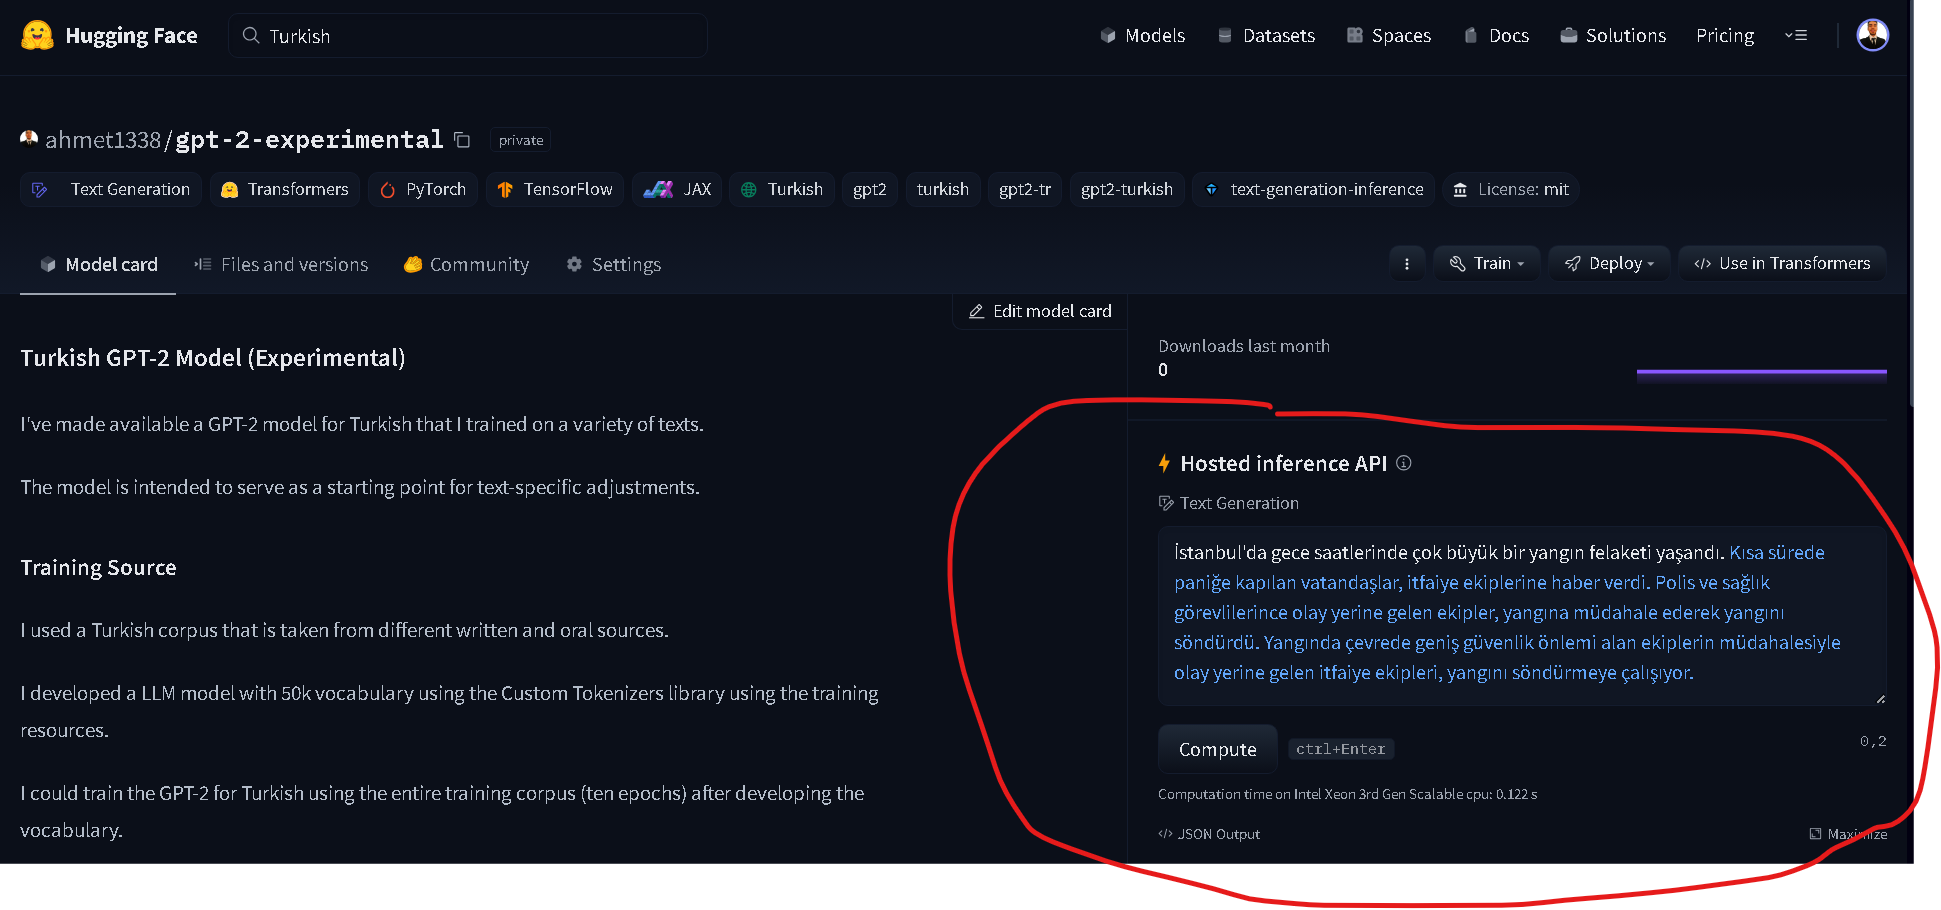